In [7]:
# EOmaps example 9:  Data analysis widgets - Interacting with a database
%matplotlib widget
from eomaps import MapsGrid, Maps
import pandas as pd
import numpy as np

# just a helper-function to calculate axis-limits with a margin
def get_limits(data, margin=0.05):
    mi, ma = np.nanmin(data), np.nanmax(data)
    dm = margin * (ma - mi)
    return mi - dm, ma + dm


In [8]:
# ============== create a random database =============
length, Nlon, Nlat = 1000, 100, 50
lonmin, lonmax, latmin, latmax = -70, 175, 0, 75

database = np.full((Nlon * Nlat, length), np.nan)
for i in range(Nlon * Nlat):
    size = np.random.randint(1, length)
    x = np.random.normal(loc=np.random.rand(), scale=np.random.rand(), size=size)
    np.put(database, range(i * length, i * length + size), x)
lon, lat = np.meshgrid(
    np.linspace(lonmin, lonmax, Nlon), np.linspace(latmin, latmax, Nlat)
)

IDs = [f"point_{i}" for i in range(Nlon * Nlat)]
database = pd.DataFrame(database, index=IDs)
coords = pd.DataFrame(dict(lon=lon.flat, lat=lat.flat), index=IDs)

# -------- calculate the number of values in each dataset
#          (e.g. the data actually shown on the map)
data = pd.DataFrame(dict(count=database.count(axis=1), **coords))
# =====================================================

D:\python_modules\eomaps\eomaps\eomaps.py:461: UserWarning: EOmaps disables matplotlib's interactive mode (e.g. 'plt.ioff()') when using the 'ipympl' backend to avoid recursions during callbacks!
  "EOmaps disables matplotlib's interactive mode (e.g. 'plt.ioff()') "


EOmaps: Parameter was set to: 'count'


D:\python_modules\eomaps\eomaps\eomaps.py:1146: UserWarning: EOmaps: classification bins outside of value-range... bins have been updated!
  "EOmaps: classification bins outside of value-range..."


FETCHTED A BACKGROUND


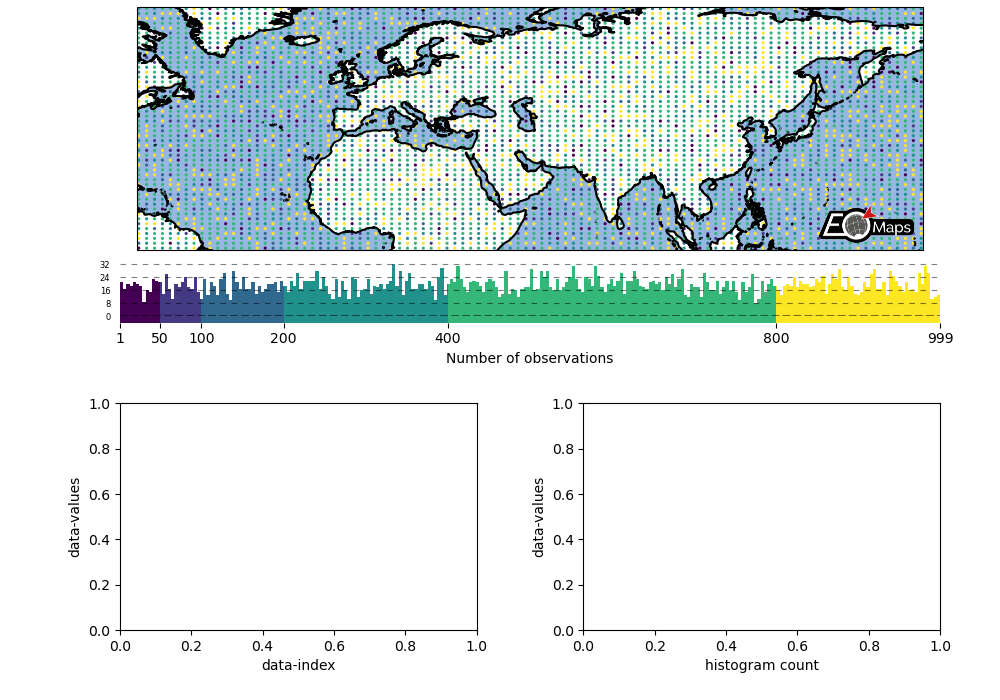

In [9]:
# -------- initialize a MapsGrid with a map on top and 2 ordinary axes below
mg = MapsGrid(
    2,
    2,
    m_inits=dict(top=(0, slice(0, 2))),
    ax_inits=dict(left=(1, 0), right=(1, 1)),
    height_ratios=(3, 2),
    figsize=(10,7)
)

mg.add_feature.preset.ocean()
mg.add_feature.preset.coastline()

# -------- set the specs for the Maps-object of the grid and plot the map
mg.m_top.set_data(data=data, xcoord="lon", ycoord="lat", crs=4326)
mg.m_top.set_classify_specs(
    scheme=Maps.CLASSIFIERS.UserDefined, bins=[50, 100, 200, 400, 800]
)
mg.m_top.set_shape.ellipses(radius=0.5)
mg.m_top.plot_map()

# -------- set some axis labels
mg.ax_left.set_ylabel("data-values")
mg.ax_left.set_xlabel("data-index")
mg.ax_right.set_ylabel("data-values")
mg.ax_right.set_xlabel("histogram count")

# -------- add the axes to the blit-manager so that their artists
#          as well as axis limits etc. are dynamically updated
mg.parent.BM.add_artist(mg.ax_left)
mg.parent.BM.add_artist(mg.ax_right)

# -------- define a custom callback function to update the plots
def update_plots(self, ID, **kwargs):
    # get the data
    x = database.loc[ID].dropna()

    # plot the lines and histograms
    (l,) = mg.ax_left.plot(x, lw=0.5, marker=".", c="C0")
    cnt, val, art = mg.ax_right.hist(
        x.values, bins=50, orientation="horizontal", fc="C0"
    )
    # add all artists as "temporary artists" so that they are removed
    # when the next datapoint is selected
    for a in [l, *art]:
        mg.m_top.cb.pick.add_temporary_artist(a)

    # manually set the axis limits (autoscaling not always works as expected)
    mg.ax_left.set_ylim(*get_limits(x))
    mg.ax_left.set_xlim(*get_limits(x.index))
    mg.ax_right.set_ylim(*get_limits(x))
    mg.ax_right.set_xlim(*get_limits(cnt))


# attach the custom callback (and some pre-defined)
mg.m_top.cb.pick.attach(update_plots)
mg.m_top.cb.pick.attach.annotate()
mg.m_top.cb.pick.attach.mark(permanent=False, buffer=1, fc="none", ec="r")
mg.m_top.cb.pick.attach.mark(permanent=False, buffer=2, fc="none", ec="r", ls=":")


# add a colorbar
mg.m_top.add_colorbar(0.25, left=0, right=0, label="Number of observations")
mg.m_top.figure.ax_cb_plot.tick_params(labelsize=6)

# update the padding for the axes
mg.subplots_adjust(bottom=0.1, left=0.12, right=0.94, wspace=0.3, hspace=0.2)

mg.add_logo()